In [1]:
import os

run_on_local = 1

if run_on_local == 1:
    working_directory = r'C:\Users\ODIN\Desktop\ml_final'
    os.chdir(working_directory)
    print("Current Working Directory: ", os.getcwd())
else:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir /content/data
    !tar -xvzf /content/drive/MyDrive/ML_final/CUB_200_2011.tgz -C /content/data

Current Working Directory:  C:\Users\ODIN\Desktop\ml_final


In [2]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [3]:
if run_on_local == 1:
    %cd C:\Users\ODIN\Desktop\ml_final\

C:\Users\ODIN\Desktop\ml_final


In [4]:
# Create Training/Val Loss Graphs
def create_graph(epoch_train_loss, epoch_val_loss):
    plt.plot(epoch_train_loss, label='Training Loss')
    plt.plot(epoch_val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()


In [5]:
# Early Stopping
# https://www.youtube.com/watch?v=lMMlbmfvKDQ
# https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_03_4_early_stop.ipynb

import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


In [6]:
#check aviable weights
import torch

weight_enum = torch.hub.load("pytorch/vision", "get_model_weights", name="inception_v3")
print([weight for weight in weight_enum])

[Inception_V3_Weights.IMAGENET1K_V1]


Using cache found in C:\Users\ODIN/.cache\torch\hub\pytorch_vision_main


#VGG16

In [7]:
transform = transforms.Compose([
    transforms.Resize((224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#dataset = torchvision.datasets.ImageFolder(root='/content/data/CUB_200_2011/images', transform=transform
dataset = torchvision.datasets.ImageFolder(root='./content/data/CUB_200_2011/images', transform=transform)
# Split to 80%/10%/10%

train_split = int(len(dataset) * .8)
val_split = int(len(dataset) * .1)
test_split = int(len(dataset) * .1)

#Make sure splits match 1:1 with dataset
total = train_split + val_split + test_split
if total < len(dataset):
    train_split = train_split + (len(dataset) - total)



print(dataset, train_split, val_split, test_split, train_split + val_split + test_split )
train, val, test = torch.utils.data.random_split(dataset, [train_split, val_split, test_split])

num_workers=2
batch_size=16

trainLoader = DataLoader(train , batch_size=batch_size,
                                           num_workers=num_workers,  shuffle=True)
valLoader = DataLoader(val, batch_size=batch_size,
                                          num_workers=num_workers )
testLoader = DataLoader(test, batch_size=batch_size,
                                          num_workers=num_workers)


Dataset ImageFolder
    Number of datapoints: 11788
    Root location: ./content/data/CUB_200_2011/images
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 9432 1178 1178 11788


In [8]:
import torchvision.models as models

torch.cuda.empty_cache()

weightz = models.get_model_weights("vgg16")
weightz = weightz.DEFAULT
print(weightz)

vgg16 = models.vgg16(weights=weightz)

num_classes = len(dataset.classes)
print("classes:", num_classes)

vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Create an object of the model
vgg16 = vgg16.to("cuda")

# optimizer
optimizer = optim.RMSprop(vgg16.parameters(), lr=1e-4)

# Loss
loss_function = nn.CrossEntropyLoss()

VGG16_Weights.IMAGENET1K_V1
classes: 200


Epoch: [1/200], Train Loss: 5.1739: 100%|██████████| 590/590 [00:49<00:00, 12.00it/s]


Epoch [1/200], Val Loss: 5.3384


Epoch: [2/200], Train Loss: 4.7381: 100%|██████████| 590/590 [00:48<00:00, 12.06it/s]


Epoch [2/200], Val Loss: 5.0238


Epoch: [3/200], Train Loss: 4.3891: 100%|██████████| 590/590 [00:48<00:00, 12.12it/s]


Epoch [3/200], Val Loss: 4.7761


Epoch: [4/200], Train Loss: 4.4728: 100%|██████████| 590/590 [00:48<00:00, 12.10it/s]


Epoch [4/200], Val Loss: 4.5127


Epoch: [5/200], Train Loss: 4.6226: 100%|██████████| 590/590 [00:48<00:00, 12.12it/s]


Epoch [5/200], Val Loss: 4.4508


Epoch: [6/200], Train Loss: 4.2480: 100%|██████████| 590/590 [00:48<00:00, 12.15it/s]


Epoch [6/200], Val Loss: 4.5470


Epoch: [7/200], Train Loss: 2.6575: 100%|██████████| 590/590 [00:48<00:00, 12.16it/s]


Epoch [7/200], Val Loss: 3.4427


Epoch: [8/200], Train Loss: 3.2879: 100%|██████████| 590/590 [00:48<00:00, 12.12it/s]


Epoch [8/200], Val Loss: 3.1541


Epoch: [9/200], Train Loss: 4.1197: 100%|██████████| 590/590 [00:48<00:00, 12.14it/s]


Epoch [9/200], Val Loss: 3.2351


Epoch: [10/200], Train Loss: 2.8743: 100%|██████████| 590/590 [00:48<00:00, 12.14it/s]


Epoch [10/200], Val Loss: 2.8402


Epoch: [11/200], Train Loss: 2.5149: 100%|██████████| 590/590 [00:48<00:00, 12.14it/s]


Epoch [11/200], Val Loss: 2.6330


Epoch: [12/200], Train Loss: 2.2009: 100%|██████████| 590/590 [00:48<00:00, 12.11it/s]


Epoch [12/200], Val Loss: 2.5725


Epoch: [13/200], Train Loss: 2.4307: 100%|██████████| 590/590 [00:48<00:00, 12.12it/s]


Epoch [13/200], Val Loss: 2.5110


Epoch: [14/200], Train Loss: 2.1352: 100%|██████████| 590/590 [00:48<00:00, 12.10it/s]


Epoch [14/200], Val Loss: 2.3245


Epoch: [15/200], Train Loss: 1.8090: 100%|██████████| 590/590 [00:48<00:00, 12.11it/s]


Epoch [15/200], Val Loss: 2.5099


Epoch: [16/200], Train Loss: 1.1289: 100%|██████████| 590/590 [00:48<00:00, 12.13it/s]


Epoch [16/200], Val Loss: 2.1743


Epoch: [17/200], Train Loss: 2.2327: 100%|██████████| 590/590 [00:48<00:00, 12.16it/s]


Epoch [17/200], Val Loss: 2.4330


Epoch: [18/200], Train Loss: 1.2988: 100%|██████████| 590/590 [00:48<00:00, 12.16it/s]


Epoch [18/200], Val Loss: 2.1054


Epoch: [19/200], Train Loss: 2.7737: 100%|██████████| 590/590 [00:48<00:00, 12.12it/s]


Epoch [19/200], Val Loss: 2.1236


Epoch: [20/200], Train Loss: 0.8793: 100%|██████████| 590/590 [00:48<00:00, 12.13it/s]


Epoch [20/200], Val Loss: 2.0284


Epoch: [21/200], Train Loss: 0.9149: 100%|██████████| 590/590 [00:47<00:00, 12.31it/s]


Epoch [21/200], Val Loss: 2.0370


Epoch: [22/200], Train Loss: 1.5105: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [22/200], Val Loss: 2.2706


Epoch: [23/200], Train Loss: 0.5988: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [23/200], Val Loss: 2.0939


Epoch: [24/200], Train Loss: 2.0816: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [24/200], Val Loss: 2.1345


Epoch: [25/200], Train Loss: 1.3214: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [25/200], Val Loss: 2.1616


Epoch: [26/200], Train Loss: 0.6057: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [26/200], Val Loss: 1.9552


Epoch: [27/200], Train Loss: 1.6533: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [27/200], Val Loss: 2.0486


Epoch: [28/200], Train Loss: 1.3099: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [28/200], Val Loss: 2.0576


Epoch: [29/200], Train Loss: 1.0383: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [29/200], Val Loss: 2.1205


Epoch: [30/200], Train Loss: 0.3055: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [30/200], Val Loss: 1.9942


Epoch: [31/200], Train Loss: 1.8550: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [31/200], Val Loss: 2.0875


Epoch: [32/200], Train Loss: 1.4884: 100%|██████████| 590/590 [00:47<00:00, 12.54it/s]


Epoch [32/200], Val Loss: 2.0524


Epoch: [33/200], Train Loss: 0.5389: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [33/200], Val Loss: 1.9432


Epoch: [34/200], Train Loss: 0.8841: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [34/200], Val Loss: 2.0123


Epoch: [35/200], Train Loss: 2.3675: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [35/200], Val Loss: 2.1756


Epoch: [36/200], Train Loss: 0.5220: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [36/200], Val Loss: 2.0091


Epoch: [37/200], Train Loss: 1.0310: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [37/200], Val Loss: 2.1560


Epoch: [38/200], Train Loss: 1.2265: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [38/200], Val Loss: 3.0180


Epoch: [39/200], Train Loss: 0.5948: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [39/200], Val Loss: 2.1877


Epoch: [40/200], Train Loss: 1.0418: 100%|██████████| 590/590 [00:47<00:00, 12.54it/s]


Epoch [40/200], Val Loss: 2.2046


Epoch: [41/200], Train Loss: 0.7286: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [41/200], Val Loss: 2.2250


Epoch: [42/200], Train Loss: 0.4685: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [42/200], Val Loss: 2.2141


Epoch: [43/200], Train Loss: 0.3175: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [43/200], Val Loss: 2.2222


Epoch: [44/200], Train Loss: 1.1708: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [44/200], Val Loss: 2.2839


Epoch: [45/200], Train Loss: 1.1300: 100%|██████████| 590/590 [00:47<00:00, 12.54it/s]


Epoch [45/200], Val Loss: 2.0701


Epoch: [46/200], Train Loss: 0.3512: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [46/200], Val Loss: 2.1984


Epoch: [47/200], Train Loss: 0.2710: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [47/200], Val Loss: 2.2671


Epoch: [48/200], Train Loss: 2.1497: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [48/200], Val Loss: 2.2789


Epoch: [49/200], Train Loss: 0.1555: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [49/200], Val Loss: 2.1301


Epoch: [50/200], Train Loss: 0.1581: 100%|██████████| 590/590 [00:47<00:00, 12.52it/s]


Epoch [50/200], Val Loss: 2.0666


Epoch: [51/200], Train Loss: 0.6977: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [51/200], Val Loss: 2.4139


Epoch: [52/200], Train Loss: 0.1984: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [52/200], Val Loss: 2.5332


Epoch: [53/200], Train Loss: 1.6293: 100%|██████████| 590/590 [00:47<00:00, 12.53it/s]


Epoch [53/200], Val Loss: 2.3565
Training complete.


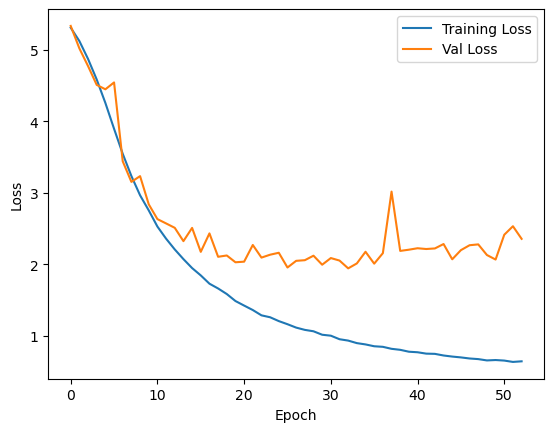

In [9]:
import tqdm

es = EarlyStopping(patience=20, min_delta=0, restore_best_weights=True)


epoch_train_loss = []
epoch_val_loss = []

num_epochs = 200
for epoch in range(num_epochs):
    # Train
    train_loss = []
    vgg16.train()
    pbar = tqdm.tqdm(trainLoader, total=len(trainLoader))
    for images, labels in pbar:
        images = images.to("cuda")
        labels = labels.to("cuda")

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        pbar.set_description(f"Epoch: [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    avg_train_loss = np.mean(train_loss)
    epoch_train_loss.append(avg_train_loss)

    # Validation
    vgg16.eval()
    val_loss = []
    with torch.no_grad():
        for images, labels in valLoader:
            images = images.to("cuda")
            labels = labels.to("cuda")
            outputs = vgg16(images)
            loss = loss_function(outputs, labels)
            val_loss.append(loss.item())

    avg_val_loss = np.mean(val_loss)
    epoch_val_loss.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {np.mean(avg_val_loss):.4f}')

    # Check for ES
    if es(vgg16, avg_val_loss):
        pbar.set_description(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, {es.status}")
        break
    else:
        pbar.set_description(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete.")
create_graph(epoch_train_loss, epoch_val_loss)


In [11]:
#Test the model
y_test = []
y_test_predict = []

vgg16.eval()
for images, labels in testLoader:
    images = images.to("cuda")
    labels = labels.to("cuda")

    with torch.no_grad():
        outputs = vgg16(images).cpu()
        _, predicted = torch.max(outputs, 1)
        y_test_predict.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())

print("Test Accuracy: ", accuracy_score(y_test, y_test_predict))

Test Accuracy:  0.5628183361629882


In [12]:

if run_on_local == 1:
    save_path = './'
else:
    save_path = '/content/drive/MyDrive/ML_final/'

torch.save({
            'epoch': epoch,
            'model_state_dict': vgg16.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, save_path + '200_vgg16.pth')

In [13]:
# model = vgg16
# optimizer = optimizer

# checkpoint = torch.load(save_path + '200_vgg16.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()

In [14]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image


# #image_path = '/content/drive/MyDrive/ML_final/sootyalbatross.jpeg'  # Path to your test image
# image_path = './LOFrJSL.jpeg'
# image = Image.open(image_path)


# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Apply the transform to the image
# input_tensor = transform(image)
# input_tensor = input_tensor.unsqueeze(0)
# input_tensor = input_tensor.to('cuda')

# # Match classname to index
# idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# # Predict
# model.eval()
# with torch.no_grad():
#     output = model(input_tensor)
#     _, predicted_index = torch.max(output, 1)
#     predicted_index = predicted_index.item()

# predicted_class_name = idx_to_class[predicted_index]
# print(predicted_class_name)



#Inception V3

In [15]:
transform = transforms.Compose([
    transforms.Resize((299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#dataset = torchvision.datasets.ImageFolder(root='/content/data/CUB_200_2011/images', transform=transform
dataset = torchvision.datasets.ImageFolder(root='./content/data/CUB_200_2011/images', transform=transform)
# Split to 80%/10%/10%

train_split = int(len(dataset) * .8)
val_split = int(len(dataset) * .1)
test_split = int(len(dataset) * .1)

#Make sure splits match 1:1 with dataset
total = train_split + val_split + test_split
if total < len(dataset):
    train_split = train_split + (len(dataset) - total)



print(dataset, train_split, val_split, test_split, train_split + val_split + test_split )
train, val, test = torch.utils.data.random_split(dataset, [train_split, val_split, test_split])

num_workers=2
batch_size=16

trainLoader = DataLoader(train , batch_size=batch_size,
                                           num_workers=num_workers,  shuffle=True)
valLoader = DataLoader(val, batch_size=batch_size,
                                          num_workers=num_workers )
testLoader = DataLoader(test, batch_size=batch_size,
                                          num_workers=num_workers)


Dataset ImageFolder
    Number of datapoints: 11788
    Root location: ./content/data/CUB_200_2011/images
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 9432 1178 1178 11788


In [17]:
import torchvision.models as models
from torch.optim import lr_scheduler

torch.cuda.empty_cache()

weightz = models.get_model_weights("inception_v3")
weightz = weightz.DEFAULT
print(weightz)

inception = models.inception_v3(weights=weightz)

for param in inception.parameters():
    param.requires_grad = False

num_classes = len(dataset.classes)
print("classes:", num_classes)

num_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_features, num_classes)

num_features = inception.fc.in_features
inception.fc = torch.nn.Linear(num_features, num_classes)



params_to_update = []
for param in inception.fc.parameters():
    param.requires_grad = True

# Create an object of the model
inception = inception.to("cuda")


# optimizer
optimizer = optim.RMSprop(inception.parameters(), lr=1e-4)

# Loss
loss_function = nn.CrossEntropyLoss()

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

Inception_V3_Weights.IMAGENET1K_V1
classes: 200


Epoch: [1/200], Train Loss: 6.9287: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [1/200], Val Loss: 5.0628


Epoch: [2/200], Train Loss: 6.2354: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [2/200], Val Loss: 4.8084


Epoch: [3/200], Train Loss: 6.1094: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [3/200], Val Loss: 4.6188


Epoch: [4/200], Train Loss: 6.4945: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [4/200], Val Loss: 4.4459


Epoch: [5/200], Train Loss: 6.0278: 100%|██████████| 590/590 [00:59<00:00,  9.93it/s]


Epoch [5/200], Val Loss: 4.2976


Epoch: [6/200], Train Loss: 6.5216: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [6/200], Val Loss: 4.1718


Epoch: [7/200], Train Loss: 4.9229: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [7/200], Val Loss: 4.0221


Epoch: [8/200], Train Loss: 5.2013: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [8/200], Val Loss: 3.9208


Epoch: [9/200], Train Loss: 5.9435: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [9/200], Val Loss: 3.8486


Epoch: [10/200], Train Loss: 4.4614: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [10/200], Val Loss: 3.7417


Epoch: [11/200], Train Loss: 5.3297: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [11/200], Val Loss: 3.6459


Epoch: [12/200], Train Loss: 4.4241: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [12/200], Val Loss: 3.5400


Epoch: [13/200], Train Loss: 5.2229: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [13/200], Val Loss: 3.5227


Epoch: [14/200], Train Loss: 4.2076: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [14/200], Val Loss: 3.4670


Epoch: [15/200], Train Loss: 5.2962: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [15/200], Val Loss: 3.4098


Epoch: [16/200], Train Loss: 4.7644: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [16/200], Val Loss: 3.3395


Epoch: [17/200], Train Loss: 4.6174: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [17/200], Val Loss: 3.3404


Epoch: [18/200], Train Loss: 3.5934: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [18/200], Val Loss: 3.3116


Epoch: [19/200], Train Loss: 4.3071: 100%|██████████| 590/590 [00:59<00:00,  9.93it/s]


Epoch [19/200], Val Loss: 3.2770


Epoch: [20/200], Train Loss: 4.0145: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [20/200], Val Loss: 3.1892


Epoch: [21/200], Train Loss: 4.3692: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [21/200], Val Loss: 3.2279


Epoch: [22/200], Train Loss: 5.4080: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [22/200], Val Loss: 3.1896


Epoch: [23/200], Train Loss: 3.0690: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [23/200], Val Loss: 3.0948


Epoch: [24/200], Train Loss: 5.1133: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [24/200], Val Loss: 3.0513


Epoch: [25/200], Train Loss: 2.9396: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [25/200], Val Loss: 3.0320


Epoch: [26/200], Train Loss: 4.7519: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [26/200], Val Loss: 3.0386


Epoch: [27/200], Train Loss: 3.5548: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [27/200], Val Loss: 3.0083


Epoch: [28/200], Train Loss: 4.6252: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [28/200], Val Loss: 2.9832


Epoch: [29/200], Train Loss: 3.3220: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [29/200], Val Loss: 3.0099


Epoch: [30/200], Train Loss: 3.2943: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [30/200], Val Loss: 2.9294


Epoch: [31/200], Train Loss: 3.7098: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [31/200], Val Loss: 2.9418


Epoch: [32/200], Train Loss: 3.2108: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [32/200], Val Loss: 2.9349


Epoch: [33/200], Train Loss: 3.8803: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [33/200], Val Loss: 2.9143


Epoch: [34/200], Train Loss: 3.4905: 100%|██████████| 590/590 [00:59<00:00,  9.94it/s]


Epoch [34/200], Val Loss: 2.8857


Epoch: [35/200], Train Loss: 4.4868: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [35/200], Val Loss: 2.8852


Epoch: [36/200], Train Loss: 3.2694: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [36/200], Val Loss: 2.8778


Epoch: [37/200], Train Loss: 4.4382: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [37/200], Val Loss: 2.8307


Epoch: [38/200], Train Loss: 2.2516: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [38/200], Val Loss: 2.7698


Epoch: [39/200], Train Loss: 3.8948: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [39/200], Val Loss: 2.7810


Epoch: [40/200], Train Loss: 4.4331: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [40/200], Val Loss: 2.8378


Epoch: [41/200], Train Loss: 3.6202: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [41/200], Val Loss: 2.7662


Epoch: [42/200], Train Loss: 4.4874: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [42/200], Val Loss: 2.7520


Epoch: [43/200], Train Loss: 3.7306: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [43/200], Val Loss: 2.7858


Epoch: [44/200], Train Loss: 3.9833: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [44/200], Val Loss: 2.7229


Epoch: [45/200], Train Loss: 3.6332: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [45/200], Val Loss: 2.7482


Epoch: [46/200], Train Loss: 2.7994: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [46/200], Val Loss: 2.7711


Epoch: [47/200], Train Loss: 3.9521: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [47/200], Val Loss: 2.7035


Epoch: [48/200], Train Loss: 3.9008: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [48/200], Val Loss: 2.7190


Epoch: [49/200], Train Loss: 4.4401: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [49/200], Val Loss: 2.7315


Epoch: [50/200], Train Loss: 4.1974: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [50/200], Val Loss: 2.7561


Epoch: [51/200], Train Loss: 4.2721: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [51/200], Val Loss: 2.7156


Epoch: [52/200], Train Loss: 4.2666: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [52/200], Val Loss: 2.7133


Epoch: [53/200], Train Loss: 3.2081: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [53/200], Val Loss: 2.7372


Epoch: [54/200], Train Loss: 3.5625: 100%|██████████| 590/590 [00:59<00:00,  9.93it/s]


Epoch [54/200], Val Loss: 2.6994


Epoch: [55/200], Train Loss: 4.0377: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [55/200], Val Loss: 2.6728


Epoch: [56/200], Train Loss: 5.2236: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [56/200], Val Loss: 2.6420


Epoch: [57/200], Train Loss: 3.7495: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [57/200], Val Loss: 2.7174


Epoch: [58/200], Train Loss: 3.5363: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [58/200], Val Loss: 2.6434


Epoch: [59/200], Train Loss: 3.7775: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [59/200], Val Loss: 2.6740


Epoch: [60/200], Train Loss: 3.0951: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [60/200], Val Loss: 2.7171


Epoch: [61/200], Train Loss: 3.2265: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [61/200], Val Loss: 2.6455


Epoch: [62/200], Train Loss: 4.3705: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [62/200], Val Loss: 2.6518


Epoch: [63/200], Train Loss: 5.2468: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [63/200], Val Loss: 2.6521


Epoch: [64/200], Train Loss: 3.9702: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [64/200], Val Loss: 2.6233


Epoch: [65/200], Train Loss: 4.4662: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [65/200], Val Loss: 2.6183


Epoch: [66/200], Train Loss: 3.2475: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [66/200], Val Loss: 2.6474


Epoch: [67/200], Train Loss: 2.9403: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [67/200], Val Loss: 2.6723


Epoch: [68/200], Train Loss: 4.5784: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [68/200], Val Loss: 2.6298


Epoch: [69/200], Train Loss: 4.0411: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [69/200], Val Loss: 2.6366


Epoch: [70/200], Train Loss: 3.7452: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [70/200], Val Loss: 2.6013


Epoch: [71/200], Train Loss: 3.7906: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [71/200], Val Loss: 2.5747


Epoch: [72/200], Train Loss: 2.9510: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [72/200], Val Loss: 2.5537


Epoch: [73/200], Train Loss: 4.4149: 100%|██████████| 590/590 [00:59<00:00,  9.87it/s]


Epoch [73/200], Val Loss: 2.5991


Epoch: [74/200], Train Loss: 3.3137: 100%|██████████| 590/590 [00:59<00:00,  9.93it/s]


Epoch [74/200], Val Loss: 2.5645


Epoch: [75/200], Train Loss: 2.9347: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [75/200], Val Loss: 2.6819


Epoch: [76/200], Train Loss: 2.8136: 100%|██████████| 590/590 [00:59<00:00,  9.87it/s]


Epoch [76/200], Val Loss: 2.6000


Epoch: [77/200], Train Loss: 4.2745: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [77/200], Val Loss: 2.6540


Epoch: [78/200], Train Loss: 2.8489: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [78/200], Val Loss: 2.5983


Epoch: [79/200], Train Loss: 2.7090: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [79/200], Val Loss: 2.5590


Epoch: [80/200], Train Loss: 4.0158: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [80/200], Val Loss: 2.6192


Epoch: [81/200], Train Loss: 4.4313: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [81/200], Val Loss: 2.6062


Epoch: [82/200], Train Loss: 3.0030: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [82/200], Val Loss: 2.5125


Epoch: [83/200], Train Loss: 3.7730: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [83/200], Val Loss: 2.6085


Epoch: [84/200], Train Loss: 2.7911: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [84/200], Val Loss: 2.5652


Epoch: [85/200], Train Loss: 4.2813: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [85/200], Val Loss: 2.5709


Epoch: [86/200], Train Loss: 4.4915: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [86/200], Val Loss: 2.5540


Epoch: [87/200], Train Loss: 2.4995: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [87/200], Val Loss: 2.5545


Epoch: [88/200], Train Loss: 2.6700: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [88/200], Val Loss: 2.5597


Epoch: [89/200], Train Loss: 2.5253: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [89/200], Val Loss: 2.4939


Epoch: [90/200], Train Loss: 1.9459: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [90/200], Val Loss: 2.5307


Epoch: [91/200], Train Loss: 4.5435: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [91/200], Val Loss: 2.5513


Epoch: [92/200], Train Loss: 2.8260: 100%|██████████| 590/590 [00:59<00:00,  9.93it/s]


Epoch [92/200], Val Loss: 2.5261


Epoch: [93/200], Train Loss: 3.2622: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [93/200], Val Loss: 2.5112


Epoch: [94/200], Train Loss: 3.1503: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [94/200], Val Loss: 2.5825


Epoch: [95/200], Train Loss: 4.5632: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [95/200], Val Loss: 2.5055


Epoch: [96/200], Train Loss: 3.5194: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [96/200], Val Loss: 2.5490


Epoch: [97/200], Train Loss: 3.2202: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [97/200], Val Loss: 2.5456


Epoch: [98/200], Train Loss: 1.6353: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [98/200], Val Loss: 2.5322


Epoch: [99/200], Train Loss: 3.5414: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [99/200], Val Loss: 2.4947


Epoch: [100/200], Train Loss: 4.6503: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [100/200], Val Loss: 2.5156


Epoch: [101/200], Train Loss: 3.7923: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [101/200], Val Loss: 2.5037


Epoch: [102/200], Train Loss: 2.7042: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [102/200], Val Loss: 2.4934


Epoch: [103/200], Train Loss: 2.2996: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [103/200], Val Loss: 2.5397


Epoch: [104/200], Train Loss: 3.1903: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [104/200], Val Loss: 2.5070


Epoch: [105/200], Train Loss: 3.4973: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [105/200], Val Loss: 2.4593


Epoch: [106/200], Train Loss: 4.2383: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [106/200], Val Loss: 2.5495


Epoch: [107/200], Train Loss: 2.1124: 100%|██████████| 590/590 [01:00<00:00,  9.82it/s]


Epoch [107/200], Val Loss: 2.4594


Epoch: [108/200], Train Loss: 2.8101: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [108/200], Val Loss: 2.5566


Epoch: [109/200], Train Loss: 2.5673: 100%|██████████| 590/590 [00:59<00:00,  9.89it/s]


Epoch [109/200], Val Loss: 2.5168


Epoch: [110/200], Train Loss: 2.7791: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [110/200], Val Loss: 2.4636


Epoch: [111/200], Train Loss: 2.3704: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [111/200], Val Loss: 2.5158


Epoch: [112/200], Train Loss: 3.1545: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [112/200], Val Loss: 2.5129


Epoch: [113/200], Train Loss: 4.8968: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [113/200], Val Loss: 2.5128


Epoch: [114/200], Train Loss: 4.0574: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [114/200], Val Loss: 2.5405


Epoch: [115/200], Train Loss: 4.3244: 100%|██████████| 590/590 [00:59<00:00,  9.88it/s]


Epoch [115/200], Val Loss: 2.5087


Epoch: [116/200], Train Loss: 3.5648: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [116/200], Val Loss: 2.4849


Epoch: [117/200], Train Loss: 3.6359: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [117/200], Val Loss: 2.5186


Epoch: [118/200], Train Loss: 2.6738: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [118/200], Val Loss: 2.5196


Epoch: [119/200], Train Loss: 2.7551: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [119/200], Val Loss: 2.5293


Epoch: [120/200], Train Loss: 4.2167: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [120/200], Val Loss: 2.4683


Epoch: [121/200], Train Loss: 2.9525: 100%|██████████| 590/590 [00:59<00:00,  9.91it/s]


Epoch [121/200], Val Loss: 2.5001


Epoch: [122/200], Train Loss: 3.3669: 100%|██████████| 590/590 [00:59<00:00,  9.92it/s]


Epoch [122/200], Val Loss: 2.6120


Epoch: [123/200], Train Loss: 2.6844: 100%|██████████| 590/590 [00:59<00:00,  9.95it/s]


Epoch [123/200], Val Loss: 2.5039


Epoch: [124/200], Train Loss: 4.6334: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [124/200], Val Loss: 2.5496


Epoch: [125/200], Train Loss: 4.9822: 100%|██████████| 590/590 [00:59<00:00,  9.90it/s]


Epoch [125/200], Val Loss: 2.4789
Training complete.


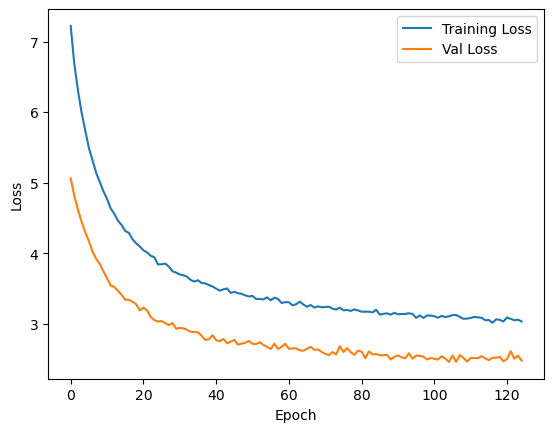

In [18]:
import tqdm

es = EarlyStopping(patience=20, min_delta=0, restore_best_weights=True)

epoch_train_loss = []
epoch_val_loss = []

num_epochs = 200
for epoch in range(num_epochs):
    # Train
    train_loss = []
    #scheduler.step()
    inception.train()
    pbar = tqdm.tqdm(trainLoader, total=len(trainLoader))
    for images, labels in pbar:
        images = images.to("cuda")
        labels = labels.to("cuda")

        optimizer.zero_grad()

        outputs, aux_outputs = inception(images)
        loss1 = loss_function(outputs, labels)
        loss2 = loss_function(aux_outputs, labels)
        loss = loss1 + 0.4*loss2

        # loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        pbar.set_description(f"Epoch: [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    avg_train_loss = np.mean(train_loss)
    epoch_train_loss.append(avg_train_loss)

    # Validation
    inception.eval()
    val_loss = []
    with torch.no_grad():
        for images, labels in valLoader:
            images = images.to("cuda")
            labels = labels.to("cuda")
            outputs = inception(images)
            loss = loss_function(outputs, labels)
            val_loss.append(loss.item())

    avg_val_loss = np.mean(val_loss)
    epoch_val_loss.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {np.mean(avg_val_loss):.4f}')

    # Check for ES
    if es(inception, avg_val_loss):
        pbar.set_description(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, {es.status}")
        break
    else:
        pbar.set_description(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete.")
create_graph(epoch_train_loss, epoch_val_loss)


In [19]:
#Test the model
y_test = []
y_test_predict = []

inception.eval()
for images, labels in testLoader:
    images = images.to("cuda")
    labels = labels.to("cuda")

    with torch.no_grad():
        outputs = inception(images).cpu()
        _, predicted = torch.max(outputs, 1)
        y_test_predict.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())

print("Test Accuracy: ", accuracy_score(y_test, y_test_predict))

Test Accuracy:  0.3853989813242784


In [20]:

if run_on_local == 1:
    save_path = './'
else:
    save_path = '/content/drive/MyDrive/ML_final/'

torch.save({
            'epoch': epoch,
            'model_state_dict': inception.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, save_path + '200_inception.pth')

In [21]:
# model = inception
# optimizer = optimizer

# checkpoint = torch.load(save_path + '200_inception.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()

In [22]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image


# #image_path = '/content/drive/MyDrive/ML_final/sootyalbatross.jpeg'  # Path to your test image
# image_path = './LOFrJSL.jpeg'
# image = Image.open(image_path)


# transform = transforms.Compose([
#     transforms.Resize((299, 299)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Apply the transform to the image
# input_tensor = transform(image)
# input_tensor = input_tensor.unsqueeze(0)
# input_tensor = input_tensor.to('cuda')

# # Match classname to index
# idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# # Predict
# model.eval()
# with torch.no_grad():
#     output = model(input_tensor)
#     _, predicted_index = torch.max(output, 1)
#     predicted_index = predicted_index.item()

# predicted_class_name = idx_to_class[predicted_index]
# print(predicted_class_name)



#Resnet50


In [6]:
transform = transforms.Compose([
    transforms.Resize((224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#dataset = torchvision.datasets.ImageFolder(root='/content/data/CUB_200_2011/images', transform=transform
dataset = torchvision.datasets.ImageFolder(root='./content/data/CUB_200_2011/images', transform=transform)
# Split to 80%/10%/10%

train_split = int(len(dataset) * .8)
val_split = int(len(dataset) * .1)
test_split = int(len(dataset) * .1)

#Make sure splits match 1:1 with dataset
total = train_split + val_split + test_split
if total < len(dataset):
    train_split = train_split + (len(dataset) - total)



print(dataset, train_split, val_split, test_split, train_split + val_split + test_split )
train, val, test = torch.utils.data.random_split(dataset, [train_split, val_split, test_split])

num_workers=2
batch_size=16

trainLoader = DataLoader(train , batch_size=batch_size,
                                           num_workers=num_workers,  shuffle=True)
valLoader = DataLoader(val, batch_size=batch_size,
                                          num_workers=num_workers )
testLoader = DataLoader(test, batch_size=batch_size,
                                          num_workers=num_workers)

Dataset ImageFolder
    Number of datapoints: 11788
    Root location: ./content/data/CUB_200_2011/images
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 9432 1178 1178 11788


In [7]:
import torchvision.models as models


torch.cuda.empty_cache()

weightz = models.get_model_weights("resnet50")
weightz = weightz.DEFAULT
print(weightz)

resnet50 = models.resnet50(weights=weightz)

num_classes = len(dataset.classes)
print("classes:", num_classes)

for param in resnet50.parameters():
    param.requires_grad = False

num_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_features, num_classes)

# Create an object of the model
resnet50 = resnet50.to("cuda")

# optimizer
optimizer = optim.RMSprop(resnet50.parameters(), lr=1e-4)

# Loss
loss_function = nn.CrossEntropyLoss()

ResNet50_Weights.IMAGENET1K_V2
classes: 200


Epoch: [1/200], Train Loss: 4.6992: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [1/200], Val Loss: 4.7099


Epoch: [2/200], Train Loss: 4.6315: 100%|██████████| 590/590 [00:40<00:00, 14.45it/s]


Epoch [2/200], Val Loss: 4.5229


Epoch: [3/200], Train Loss: 4.5234: 100%|██████████| 590/590 [00:40<00:00, 14.42it/s]


Epoch [3/200], Val Loss: 4.3704


Epoch: [4/200], Train Loss: 3.9648: 100%|██████████| 590/590 [00:40<00:00, 14.43it/s]


Epoch [4/200], Val Loss: 4.2264


Epoch: [5/200], Train Loss: 4.3644: 100%|██████████| 590/590 [00:40<00:00, 14.45it/s]


Epoch [5/200], Val Loss: 4.1137


Epoch: [6/200], Train Loss: 3.1909: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [6/200], Val Loss: 4.0095


Epoch: [7/200], Train Loss: 3.5258: 100%|██████████| 590/590 [00:40<00:00, 14.43it/s]


Epoch [7/200], Val Loss: 3.9279


Epoch: [8/200], Train Loss: 4.0287: 100%|██████████| 590/590 [00:40<00:00, 14.40it/s]


Epoch [8/200], Val Loss: 3.8437


Epoch: [9/200], Train Loss: 3.5212: 100%|██████████| 590/590 [00:40<00:00, 14.39it/s]


Epoch [9/200], Val Loss: 3.7597


Epoch: [10/200], Train Loss: 4.0321: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [10/200], Val Loss: 3.6780


Epoch: [11/200], Train Loss: 3.7820: 100%|██████████| 590/590 [00:40<00:00, 14.43it/s]


Epoch [11/200], Val Loss: 3.6392


Epoch: [12/200], Train Loss: 3.2224: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [12/200], Val Loss: 3.5568


Epoch: [13/200], Train Loss: 3.6232: 100%|██████████| 590/590 [00:40<00:00, 14.40it/s]


Epoch [13/200], Val Loss: 3.5367


Epoch: [14/200], Train Loss: 3.4881: 100%|██████████| 590/590 [00:40<00:00, 14.39it/s]


Epoch [14/200], Val Loss: 3.4593


Epoch: [15/200], Train Loss: 3.4433: 100%|██████████| 590/590 [00:40<00:00, 14.43it/s]


Epoch [15/200], Val Loss: 3.4828


Epoch: [16/200], Train Loss: 2.7719: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [16/200], Val Loss: 3.4235


Epoch: [17/200], Train Loss: 3.1871: 100%|██████████| 590/590 [00:41<00:00, 14.39it/s]


Epoch [17/200], Val Loss: 3.3831


Epoch: [18/200], Train Loss: 4.0984: 100%|██████████| 590/590 [00:41<00:00, 14.38it/s]


Epoch [18/200], Val Loss: 3.3224


Epoch: [19/200], Train Loss: 2.5060: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [19/200], Val Loss: 3.2925


Epoch: [20/200], Train Loss: 2.7439: 100%|██████████| 590/590 [00:41<00:00, 14.34it/s]


Epoch [20/200], Val Loss: 3.2760


Epoch: [21/200], Train Loss: 3.0903: 100%|██████████| 590/590 [00:40<00:00, 14.42it/s]


Epoch [21/200], Val Loss: 3.2437


Epoch: [22/200], Train Loss: 3.0541: 100%|██████████| 590/590 [00:41<00:00, 14.22it/s]


Epoch [22/200], Val Loss: 3.2408


Epoch: [23/200], Train Loss: 3.3376: 100%|██████████| 590/590 [00:40<00:00, 14.39it/s]


Epoch [23/200], Val Loss: 3.1786


Epoch: [24/200], Train Loss: 2.8336: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [24/200], Val Loss: 3.1728


Epoch: [25/200], Train Loss: 3.5544: 100%|██████████| 590/590 [00:40<00:00, 14.40it/s]


Epoch [25/200], Val Loss: 3.1475


Epoch: [26/200], Train Loss: 3.2615: 100%|██████████| 590/590 [00:41<00:00, 14.38it/s]


Epoch [26/200], Val Loss: 3.1484


Epoch: [27/200], Train Loss: 3.3741: 100%|██████████| 590/590 [00:41<00:00, 14.30it/s]


Epoch [27/200], Val Loss: 3.0626


Epoch: [28/200], Train Loss: 2.8226: 100%|██████████| 590/590 [00:41<00:00, 14.31it/s]


Epoch [28/200], Val Loss: 3.0474


Epoch: [29/200], Train Loss: 3.1586: 100%|██████████| 590/590 [00:41<00:00, 14.37it/s]


Epoch [29/200], Val Loss: 3.0911


Epoch: [30/200], Train Loss: 2.3804: 100%|██████████| 590/590 [00:41<00:00, 14.27it/s]


Epoch [30/200], Val Loss: 3.0252


Epoch: [31/200], Train Loss: 2.4229: 100%|██████████| 590/590 [00:41<00:00, 14.30it/s]


Epoch [31/200], Val Loss: 3.0071


Epoch: [32/200], Train Loss: 3.3573: 100%|██████████| 590/590 [00:41<00:00, 14.27it/s]


Epoch [32/200], Val Loss: 2.9765


Epoch: [33/200], Train Loss: 2.8457: 100%|██████████| 590/590 [00:41<00:00, 14.19it/s]


Epoch [33/200], Val Loss: 3.0247


Epoch: [34/200], Train Loss: 2.0938: 100%|██████████| 590/590 [00:41<00:00, 14.31it/s]


Epoch [34/200], Val Loss: 2.9813


Epoch: [35/200], Train Loss: 2.8866: 100%|██████████| 590/590 [00:41<00:00, 14.28it/s]


Epoch [35/200], Val Loss: 2.9689


Epoch: [36/200], Train Loss: 2.5461: 100%|██████████| 590/590 [00:40<00:00, 14.39it/s]


Epoch [36/200], Val Loss: 2.9581


Epoch: [37/200], Train Loss: 2.1212: 100%|██████████| 590/590 [00:41<00:00, 14.35it/s]


Epoch [37/200], Val Loss: 2.9483


Epoch: [38/200], Train Loss: 3.6443: 100%|██████████| 590/590 [00:41<00:00, 14.12it/s]


Epoch [38/200], Val Loss: 2.8806


Epoch: [39/200], Train Loss: 3.0454: 100%|██████████| 590/590 [00:41<00:00, 14.25it/s]


Epoch [39/200], Val Loss: 2.8776


Epoch: [40/200], Train Loss: 2.5857: 100%|██████████| 590/590 [00:41<00:00, 14.24it/s]


Epoch [40/200], Val Loss: 2.8787


Epoch: [41/200], Train Loss: 2.3621: 100%|██████████| 590/590 [00:42<00:00, 14.03it/s]


Epoch [41/200], Val Loss: 2.9050


Epoch: [42/200], Train Loss: 2.4391: 100%|██████████| 590/590 [00:41<00:00, 14.16it/s]


Epoch [42/200], Val Loss: 2.8877


Epoch: [43/200], Train Loss: 3.6406: 100%|██████████| 590/590 [00:41<00:00, 14.18it/s]


Epoch [43/200], Val Loss: 2.8454


Epoch: [44/200], Train Loss: 2.2828: 100%|██████████| 590/590 [00:41<00:00, 14.21it/s]


Epoch [44/200], Val Loss: 2.8851


Epoch: [45/200], Train Loss: 2.3886: 100%|██████████| 590/590 [00:41<00:00, 14.34it/s]


Epoch [45/200], Val Loss: 2.8155


Epoch: [46/200], Train Loss: 2.4981: 100%|██████████| 590/590 [00:41<00:00, 14.39it/s]


Epoch [46/200], Val Loss: 2.8574


Epoch: [47/200], Train Loss: 2.8823: 100%|██████████| 590/590 [00:41<00:00, 14.38it/s]


Epoch [47/200], Val Loss: 2.8781


Epoch: [48/200], Train Loss: 2.8206: 100%|██████████| 590/590 [00:41<00:00, 14.38it/s]


Epoch [48/200], Val Loss: 2.8289


Epoch: [49/200], Train Loss: 2.0606: 100%|██████████| 590/590 [00:41<00:00, 14.36it/s]


Epoch [49/200], Val Loss: 2.7800


Epoch: [50/200], Train Loss: 2.8645: 100%|██████████| 590/590 [00:41<00:00, 14.32it/s]


Epoch [50/200], Val Loss: 2.8047


Epoch: [51/200], Train Loss: 3.0071: 100%|██████████| 590/590 [00:40<00:00, 14.45it/s]


Epoch [51/200], Val Loss: 2.7991


Epoch: [52/200], Train Loss: 2.6124: 100%|██████████| 590/590 [00:40<00:00, 14.39it/s]


Epoch [52/200], Val Loss: 2.7546


Epoch: [53/200], Train Loss: 1.8680: 100%|██████████| 590/590 [00:40<00:00, 14.40it/s]


Epoch [53/200], Val Loss: 2.7491


Epoch: [54/200], Train Loss: 2.0372: 100%|██████████| 590/590 [00:40<00:00, 14.41it/s]


Epoch [54/200], Val Loss: 2.7894


Epoch: [55/200], Train Loss: 2.4400: 100%|██████████| 590/590 [00:41<00:00, 14.35it/s]


Epoch [55/200], Val Loss: 2.7891


Epoch: [56/200], Train Loss: 1.5543: 100%|██████████| 590/590 [00:42<00:00, 13.94it/s]


Epoch [56/200], Val Loss: 2.7850


Epoch: [57/200], Train Loss: 2.5520: 100%|██████████| 590/590 [00:42<00:00, 14.01it/s]


Epoch [57/200], Val Loss: 2.7640


Epoch: [58/200], Train Loss: 2.9991: 100%|██████████| 590/590 [00:42<00:00, 14.01it/s]


Epoch [58/200], Val Loss: 2.7161


Epoch: [59/200], Train Loss: 1.6311: 100%|██████████| 590/590 [00:41<00:00, 14.26it/s]


Epoch [59/200], Val Loss: 2.6717


Epoch: [60/200], Train Loss: 2.1733: 100%|██████████| 590/590 [00:41<00:00, 14.08it/s]


Epoch [60/200], Val Loss: 2.7986


Epoch: [61/200], Train Loss: 2.1908: 100%|██████████| 590/590 [00:41<00:00, 14.20it/s]


Epoch [61/200], Val Loss: 2.7571


Epoch: [62/200], Train Loss: 3.7675: 100%|██████████| 590/590 [00:41<00:00, 14.14it/s]


Epoch [62/200], Val Loss: 2.7484


Epoch: [63/200], Train Loss: 2.2909: 100%|██████████| 590/590 [00:41<00:00, 14.15it/s]


Epoch [63/200], Val Loss: 2.7194


Epoch: [64/200], Train Loss: 2.9471: 100%|██████████| 590/590 [00:41<00:00, 14.25it/s]


Epoch [64/200], Val Loss: 2.7261


Epoch: [65/200], Train Loss: 2.6742: 100%|██████████| 590/590 [00:41<00:00, 14.25it/s]


Epoch [65/200], Val Loss: 2.6788


Epoch: [66/200], Train Loss: 1.8873: 100%|██████████| 590/590 [00:41<00:00, 14.16it/s]


Epoch [66/200], Val Loss: 2.7158


Epoch: [67/200], Train Loss: 2.7193: 100%|██████████| 590/590 [00:41<00:00, 14.28it/s]


Epoch [67/200], Val Loss: 2.6827


Epoch: [68/200], Train Loss: 1.5659: 100%|██████████| 590/590 [00:41<00:00, 14.27it/s]


Epoch [68/200], Val Loss: 2.6689


Epoch: [69/200], Train Loss: 2.2907: 100%|██████████| 590/590 [00:41<00:00, 14.36it/s]


Epoch [69/200], Val Loss: 2.7018


Epoch: [70/200], Train Loss: 2.4260: 100%|██████████| 590/590 [00:40<00:00, 14.40it/s]


Epoch [70/200], Val Loss: 2.6837


Epoch: [71/200], Train Loss: 2.5482: 100%|██████████| 590/590 [00:41<00:00, 14.38it/s]


Epoch [71/200], Val Loss: 2.7308


Epoch: [72/200], Train Loss: 1.8477: 100%|██████████| 590/590 [00:41<00:00, 14.37it/s]


Epoch [72/200], Val Loss: 2.6958


Epoch: [73/200], Train Loss: 1.9398: 100%|██████████| 590/590 [00:41<00:00, 14.22it/s]


Epoch [73/200], Val Loss: 2.6509


Epoch: [74/200], Train Loss: 2.3245: 100%|██████████| 590/590 [00:41<00:00, 14.25it/s]


Epoch [74/200], Val Loss: 2.6811


Epoch: [75/200], Train Loss: 1.6715: 100%|██████████| 590/590 [00:41<00:00, 14.35it/s]


Epoch [75/200], Val Loss: 2.6995


Epoch: [76/200], Train Loss: 1.9932: 100%|██████████| 590/590 [00:41<00:00, 14.32it/s]


Epoch [76/200], Val Loss: 2.6299


Epoch: [77/200], Train Loss: 0.9758: 100%|██████████| 590/590 [00:41<00:00, 14.31it/s]


Epoch [77/200], Val Loss: 2.6037


Epoch: [78/200], Train Loss: 2.4124: 100%|██████████| 590/590 [00:41<00:00, 14.22it/s]


Epoch [78/200], Val Loss: 2.7117


Epoch: [79/200], Train Loss: 2.1331: 100%|██████████| 590/590 [00:41<00:00, 14.08it/s]


Epoch [79/200], Val Loss: 2.6310


Epoch: [80/200], Train Loss: 2.2380: 100%|██████████| 590/590 [00:42<00:00, 13.74it/s]


Epoch [80/200], Val Loss: 2.6291


Epoch: [81/200], Train Loss: 1.7367: 100%|██████████| 590/590 [00:49<00:00, 11.95it/s]


Epoch [81/200], Val Loss: 2.6058


Epoch: [82/200], Train Loss: 1.7633: 100%|██████████| 590/590 [00:41<00:00, 14.20it/s]


Epoch [82/200], Val Loss: 2.6452


Epoch: [83/200], Train Loss: 1.5511: 100%|██████████| 590/590 [00:42<00:00, 13.96it/s]


Epoch [83/200], Val Loss: 2.6617


Epoch: [84/200], Train Loss: 2.4749: 100%|██████████| 590/590 [00:41<00:00, 14.17it/s]


Epoch [84/200], Val Loss: 2.5851


Epoch: [85/200], Train Loss: 2.1258: 100%|██████████| 590/590 [00:41<00:00, 14.19it/s]


Epoch [85/200], Val Loss: 2.6390


Epoch: [86/200], Train Loss: 2.6823: 100%|██████████| 590/590 [00:41<00:00, 14.25it/s]


Epoch [86/200], Val Loss: 2.6429


Epoch: [87/200], Train Loss: 2.1071: 100%|██████████| 590/590 [00:41<00:00, 14.23it/s]


Epoch [87/200], Val Loss: 2.5947


Epoch: [88/200], Train Loss: 2.3359: 100%|██████████| 590/590 [00:41<00:00, 14.33it/s]


Epoch [88/200], Val Loss: 2.5621


Epoch: [89/200], Train Loss: 2.7404: 100%|██████████| 590/590 [00:42<00:00, 13.97it/s]


Epoch [89/200], Val Loss: 2.6125


Epoch: [90/200], Train Loss: 2.4194: 100%|██████████| 590/590 [00:42<00:00, 13.98it/s]


Epoch [90/200], Val Loss: 2.6721


Epoch: [91/200], Train Loss: 2.5299: 100%|██████████| 590/590 [00:42<00:00, 14.00it/s]


Epoch [91/200], Val Loss: 2.5616


Epoch: [92/200], Train Loss: 2.1313: 100%|██████████| 590/590 [00:42<00:00, 13.98it/s]


Epoch [92/200], Val Loss: 2.5579


Epoch: [93/200], Train Loss: 2.4163: 100%|██████████| 590/590 [00:41<00:00, 14.12it/s]


Epoch [93/200], Val Loss: 2.6310


Epoch: [94/200], Train Loss: 2.1932: 100%|██████████| 590/590 [00:42<00:00, 14.03it/s]


Epoch [94/200], Val Loss: 2.6412


Epoch: [95/200], Train Loss: 1.4097: 100%|██████████| 590/590 [00:41<00:00, 14.13it/s]


Epoch [95/200], Val Loss: 2.5878


Epoch: [96/200], Train Loss: 1.7149: 100%|██████████| 590/590 [00:41<00:00, 14.09it/s]


Epoch [96/200], Val Loss: 2.6308


Epoch: [97/200], Train Loss: 1.8788: 100%|██████████| 590/590 [00:41<00:00, 14.14it/s]


Epoch [97/200], Val Loss: 2.6079


Epoch: [98/200], Train Loss: 2.9500: 100%|██████████| 590/590 [00:42<00:00, 14.02it/s]


Epoch [98/200], Val Loss: 2.5838


Epoch: [99/200], Train Loss: 1.9452: 100%|██████████| 590/590 [00:42<00:00, 14.02it/s]


Epoch [99/200], Val Loss: 2.6346


Epoch: [100/200], Train Loss: 1.6881: 100%|██████████| 590/590 [00:41<00:00, 14.19it/s]


Epoch [100/200], Val Loss: 2.5727


Epoch: [101/200], Train Loss: 1.6084: 100%|██████████| 590/590 [00:41<00:00, 14.19it/s]


Epoch [101/200], Val Loss: 2.5451


Epoch: [102/200], Train Loss: 2.1927: 100%|██████████| 590/590 [00:41<00:00, 14.17it/s]


Epoch [102/200], Val Loss: 2.6038


Epoch: [103/200], Train Loss: 3.3348: 100%|██████████| 590/590 [00:41<00:00, 14.09it/s]


Epoch [103/200], Val Loss: 2.6214


Epoch: [104/200], Train Loss: 2.7201: 100%|██████████| 590/590 [00:41<00:00, 14.10it/s]


Epoch [104/200], Val Loss: 2.5523


Epoch: [105/200], Train Loss: 2.9413: 100%|██████████| 590/590 [00:42<00:00, 13.95it/s]


Epoch [105/200], Val Loss: 2.5931


Epoch: [106/200], Train Loss: 1.9413: 100%|██████████| 590/590 [00:41<00:00, 14.17it/s]


Epoch [106/200], Val Loss: 2.6083


Epoch: [107/200], Train Loss: 1.4769: 100%|██████████| 590/590 [00:40<00:00, 14.42it/s]


Epoch [107/200], Val Loss: 2.6171


Epoch: [108/200], Train Loss: 1.7240: 100%|██████████| 590/590 [00:40<00:00, 14.48it/s]


Epoch [108/200], Val Loss: 2.5555


Epoch: [109/200], Train Loss: 2.5082: 100%|██████████| 590/590 [00:40<00:00, 14.54it/s]


Epoch [109/200], Val Loss: 2.6159


Epoch: [110/200], Train Loss: 1.5095: 100%|██████████| 590/590 [00:40<00:00, 14.43it/s]


Epoch [110/200], Val Loss: 2.5576


Epoch: [111/200], Train Loss: 1.4486: 100%|██████████| 590/590 [00:40<00:00, 14.52it/s]


Epoch [111/200], Val Loss: 2.6020


Epoch: [112/200], Train Loss: 2.2867: 100%|██████████| 590/590 [00:40<00:00, 14.53it/s]


Epoch [112/200], Val Loss: 2.5432


Epoch: [113/200], Train Loss: 1.7049: 100%|██████████| 590/590 [00:40<00:00, 14.53it/s]


Epoch [113/200], Val Loss: 2.5488


Epoch: [114/200], Train Loss: 1.4061: 100%|██████████| 590/590 [00:40<00:00, 14.54it/s]


Epoch [114/200], Val Loss: 2.6197


Epoch: [115/200], Train Loss: 1.9698: 100%|██████████| 590/590 [00:40<00:00, 14.53it/s]


Epoch [115/200], Val Loss: 2.6149


Epoch: [116/200], Train Loss: 3.7912: 100%|██████████| 590/590 [00:41<00:00, 14.38it/s]


Epoch [116/200], Val Loss: 2.5105


Epoch: [117/200], Train Loss: 1.7319: 100%|██████████| 590/590 [00:40<00:00, 14.43it/s]


Epoch [117/200], Val Loss: 2.5400


Epoch: [118/200], Train Loss: 1.0563: 100%|██████████| 590/590 [00:40<00:00, 14.47it/s]


Epoch [118/200], Val Loss: 2.6112


Epoch: [119/200], Train Loss: 2.7818: 100%|██████████| 590/590 [00:40<00:00, 14.42it/s]


Epoch [119/200], Val Loss: 2.5461


Epoch: [120/200], Train Loss: 2.1327: 100%|██████████| 590/590 [00:40<00:00, 14.45it/s]


Epoch [120/200], Val Loss: 2.5852


Epoch: [121/200], Train Loss: 2.6305: 100%|██████████| 590/590 [00:41<00:00, 14.27it/s]


Epoch [121/200], Val Loss: 2.5983


Epoch: [122/200], Train Loss: 2.3090: 100%|██████████| 590/590 [00:41<00:00, 14.29it/s]


Epoch [122/200], Val Loss: 2.5580


Epoch: [123/200], Train Loss: 2.2106: 100%|██████████| 590/590 [00:41<00:00, 14.37it/s]


Epoch [123/200], Val Loss: 2.5154


Epoch: [124/200], Train Loss: 1.9397: 100%|██████████| 590/590 [00:41<00:00, 14.26it/s]


Epoch [124/200], Val Loss: 2.5342


Epoch: [125/200], Train Loss: 1.5450: 100%|██████████| 590/590 [00:40<00:00, 14.50it/s]


Epoch [125/200], Val Loss: 2.5352


Epoch: [126/200], Train Loss: 1.7191: 100%|██████████| 590/590 [00:40<00:00, 14.57it/s]


Epoch [126/200], Val Loss: 2.5310


Epoch: [127/200], Train Loss: 2.1070: 100%|██████████| 590/590 [00:41<00:00, 14.17it/s]


Epoch [127/200], Val Loss: 2.5658


Epoch: [128/200], Train Loss: 2.4760: 100%|██████████| 590/590 [00:41<00:00, 14.35it/s]


Epoch [128/200], Val Loss: 2.5498


Epoch: [129/200], Train Loss: 2.1627: 100%|██████████| 590/590 [00:40<00:00, 14.42it/s]


Epoch [129/200], Val Loss: 2.5326


Epoch: [130/200], Train Loss: 2.6033: 100%|██████████| 590/590 [00:40<00:00, 14.39it/s]


Epoch [130/200], Val Loss: 2.5921


Epoch: [131/200], Train Loss: 2.8658: 100%|██████████| 590/590 [00:41<00:00, 14.34it/s]


Epoch [131/200], Val Loss: 2.4901


Epoch: [132/200], Train Loss: 2.8016: 100%|██████████| 590/590 [00:40<00:00, 14.42it/s]


Epoch [132/200], Val Loss: 2.5806


Epoch: [133/200], Train Loss: 1.4359: 100%|██████████| 590/590 [00:41<00:00, 14.25it/s]


Epoch [133/200], Val Loss: 2.5719


Epoch: [134/200], Train Loss: 1.8535: 100%|██████████| 590/590 [00:41<00:00, 14.26it/s]


Epoch [134/200], Val Loss: 2.5633


Epoch: [135/200], Train Loss: 2.1177: 100%|██████████| 590/590 [00:41<00:00, 14.35it/s]


Epoch [135/200], Val Loss: 2.5786


Epoch: [136/200], Train Loss: 1.9200: 100%|██████████| 590/590 [00:40<00:00, 14.40it/s]


Epoch [136/200], Val Loss: 2.5887


Epoch: [137/200], Train Loss: 2.5313: 100%|██████████| 590/590 [00:41<00:00, 14.28it/s]


Epoch [137/200], Val Loss: 2.5520


Epoch: [138/200], Train Loss: 1.5337: 100%|██████████| 590/590 [00:42<00:00, 14.04it/s]


Epoch [138/200], Val Loss: 2.5569


Epoch: [139/200], Train Loss: 1.6846: 100%|██████████| 590/590 [00:42<00:00, 13.85it/s]


Epoch [139/200], Val Loss: 2.5521


Epoch: [140/200], Train Loss: 0.9661: 100%|██████████| 590/590 [00:42<00:00, 14.04it/s]


Epoch [140/200], Val Loss: 2.4967


Epoch: [141/200], Train Loss: 1.5358: 100%|██████████| 590/590 [00:41<00:00, 14.09it/s]


Epoch [141/200], Val Loss: 2.6107


Epoch: [142/200], Train Loss: 2.0793: 100%|██████████| 590/590 [00:41<00:00, 14.09it/s]


Epoch [142/200], Val Loss: 2.5870


Epoch: [143/200], Train Loss: 1.9145: 100%|██████████| 590/590 [00:42<00:00, 13.81it/s]


Epoch [143/200], Val Loss: 2.4911


Epoch: [144/200], Train Loss: 1.6193: 100%|██████████| 590/590 [00:41<00:00, 14.15it/s]


Epoch [144/200], Val Loss: 2.5528


Epoch: [145/200], Train Loss: 3.3764: 100%|██████████| 590/590 [00:41<00:00, 14.05it/s]


Epoch [145/200], Val Loss: 2.5375


Epoch: [146/200], Train Loss: 1.6138: 100%|██████████| 590/590 [00:41<00:00, 14.07it/s]


Epoch [146/200], Val Loss: 2.5235


Epoch: [147/200], Train Loss: 1.3798: 100%|██████████| 590/590 [00:42<00:00, 14.03it/s]


Epoch [147/200], Val Loss: 2.5496


Epoch: [148/200], Train Loss: 1.7276: 100%|██████████| 590/590 [00:41<00:00, 14.15it/s]


Epoch [148/200], Val Loss: 2.5740


Epoch: [149/200], Train Loss: 2.9918: 100%|██████████| 590/590 [00:41<00:00, 14.11it/s]


Epoch [149/200], Val Loss: 2.5163


Epoch: [150/200], Train Loss: 1.6871: 100%|██████████| 590/590 [00:41<00:00, 14.10it/s]


Epoch [150/200], Val Loss: 2.5432


Epoch: [151/200], Train Loss: 1.5112: 100%|██████████| 590/590 [00:42<00:00, 13.96it/s]


Epoch [151/200], Val Loss: 2.4949
Training complete.


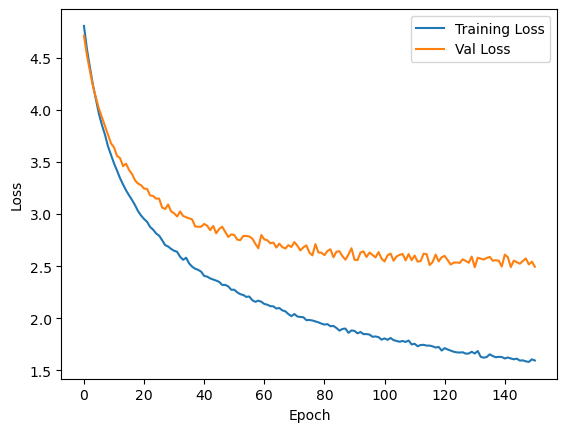

In [9]:
import tqdm

es = EarlyStopping(patience=20, min_delta=0, restore_best_weights=True)


epoch_train_loss = []
epoch_val_loss = []

num_epochs = 200
for epoch in range(num_epochs):
    # Train
    train_loss = []
    resnet50.train()
    pbar = tqdm.tqdm(trainLoader, total=len(trainLoader))
    for images, labels in pbar:
        images = images.to("cuda")
        labels = labels.to("cuda")

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        pbar.set_description(f"Epoch: [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    avg_train_loss = np.mean(train_loss)
    epoch_train_loss.append(avg_train_loss)

    # Validation
    resnet50.eval()
    val_loss = []
    with torch.no_grad():
        for images, labels in valLoader:
            images = images.to("cuda")
            labels = labels.to("cuda")
            outputs = resnet50(images)
            loss = loss_function(outputs, labels)
            val_loss.append(loss.item())

    avg_val_loss = np.mean(val_loss)
    epoch_val_loss.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {np.mean(avg_val_loss):.4f}')

    # Check for ES
    if es(resnet50, avg_val_loss):
        pbar.set_description(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, {es.status}")
        break
    else:
        pbar.set_description(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete.")
create_graph(epoch_train_loss, epoch_val_loss)


In [12]:
#Test the model
y_test = []
y_test_predict = []

resnet50.eval()
for images, labels in testLoader:
    images = images.to("cuda")
    labels = labels.to("cuda")

    with torch.no_grad():
        outputs = resnet50(images).cpu()
        _, predicted = torch.max(outputs, 1)
        y_test_predict.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())

print("Test Accuracy: ", accuracy_score(y_test, y_test_predict))

Test Accuracy:  0.37521222410865873


In [13]:

if run_on_local == 1:
    save_path = './'
else:
    save_path = '/content/drive/MyDrive/ML_final/'

torch.save({
            'epoch': epoch,
            'model_state_dict': resnet50.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, save_path + '200_resnet50.pth')

In [ ]:
# model = resnet50
# optimizer = optimizer

# checkpoint = torch.load(save_path + '200_resnet50.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image


# #image_path = '/content/drive/MyDrive/ML_final/sootyalbatross.jpeg'  # Path to your test image
# image_path = './LOFrJSL.jpeg'
# image = Image.open(image_path)


# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Apply the transform to the image
# input_tensor = transform(image)
# input_tensor = input_tensor.unsqueeze(0)
# input_tensor = input_tensor.to('cuda')

# # Match classname to index
# idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# # Predict
# model.eval()
# with torch.no_grad():
#     output = model(input_tensor)
#     _, predicted_index = torch.max(output, 1)
#     predicted_index = predicted_index.item()

# predicted_class_name = idx_to_class[predicted_index]
# print(predicted_class_name)



008.Rhinoceros_Auklet
